# Naural Networks Project

  *   Daniel Santos
  *   Maurício Sightman
  *   Paula Perazzo
  *   Pedro Manoel


## Data Processing

Before start implementing our model, we will first downaload, make a little exploration of the data we have and then process it in order to achieve a better model performance.

### Downloading

In [84]:
#installing dependency to hide unnecessary logs
!pip install gwpy --quiet
!pip install scikit-learn --quiet

In [85]:
!mkdir datasets

In [86]:
%%capture
!wget "https://drive.google.com/uc?id=1_MKWATwySO_pLbhTpKspsNgbzEy-i_Di&export=download" -O "train.csv.zip"
!unzip "train.csv.zip" -d "datasets"
!rm "train.csv.zip"

In [87]:
%%capture
!wget "https://drive.google.com/uc?id=166yA-LWwDM28SHkQFwiUX2hlwIBU-2ww&export=download" -O "test.csv.zip"
!unzip "test.csv.zip" -d "datasets"
!rm "test.csv.zip"

### Splitting

Here we will make separations of datasets in this way:


  *   70% of the trainning data for the trainning process
  *   30% of the trainning data for the validation process
  *   100% of the test data for the test process



In [299]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [300]:
train_dataset = pd.read_csv('datasets/train.csv')
test_dataset = pd.read_csv('datasets/test.csv')

validation_dataset = train_dataset.sample(frac=0.3, random_state=200)
train_dataset = train_dataset.drop(validation_dataset.index)

In [301]:
train_dataset = train_dataset.drop(['Unnamed: 0', 'id'], axis=1)
validation_dataset = validation_dataset.drop(['Unnamed: 0', 'id'], axis=1)
test_dataset = test_dataset.drop(['Unnamed: 0', 'id'], axis=1)

### Utils

In [253]:
def compare_boxplots(data, columns):
  width, total = 1/len(columns), len(columns)
  fig, ax = plt.subplots(1,total, figsize=(12, 5))
  for index, column in enumerate(columns):
    sns.boxplot(data[column], ax=ax[index%total], width=width)
  fig.show()

In [254]:
def remove_outliers_z_score(data, columns, threshold):
    z_scores = stats.zscore(data[columns])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    return data[filtered_entries]

In [255]:
def make_ranges(dataset, columns, partitions=6):
  new_df = dataset[columns]
  for column in columns:
    new_df[f'{column} Range'] = pd.cut(new_df[column], bins=partitions, labels=[f'Q{idx}' for idx in range(1, partitions+1)])
  return new_df

In [256]:
def get_analysis(dataset, columns, partitions=6):
  analysis = {}
  for column in columns:
    current = {}
    for index in range(1, partitions+1):
      cut = {}
      base = dataset[dataset[f'{column} Range'] == f'Q{index}']
      cut['count'] = base.shape[0]
      cut['min'] = base[column].min()
      cut['max'] = base[column].max()
      current[f'Q{index}'] = cut

    analysis[column] = current
  return analysis

In [257]:
def plot_analysis(analysis, column):
    counts = []
    mins = []
    maxs = []
    labels = []

    for key, value in analysis[column].items():
        counts.append(value['count'])
        mins.append(value['min'])
        maxs.append(value['max'])
        labels.append(key)

    x = range(len(labels))

    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.bar(x, counts, color='b', alpha=0.6)
    ax1.set_xlabel('Quantile Range')
    ax1.set_ylabel('Count', color='b')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)

    ax2 = ax1.twinx()
    ax2.plot(x, mins, color='r', marker='o', label='Min')
    ax2.plot(x, maxs, color='g', marker='o', label='Max')
    ax2.set_ylabel('Value', color='r')

    plt.title(f'Analysis of {column}')
    ax1.legend(['Count'], loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

In [258]:
def adjust_column_names(dataset):
  names = {'Class_Business': 'Business Class', 'Class_Eco': 'Eco Class', 'Class_Eco Plus': 'Eco Plus Class'}

  for column in dataset.columns:
    if column in names: continue
    current = column
    if 'Range' in current: current = current.replace('Range', '')
    if 'in Minutes' in current: current = current.replace('in Minutes', '')
    if '_' in current: current = current.split('_')[1]
    names[column] = current.strip().title()

  return dataset.rename(columns=names)

### Exploring

Here we will look into our dataset in order to observe which data types is inserted on it, what are the distribution and take insights.

When exploring our data, we can notice that the column **Arrival Delay in Minutes** is the only one that have some missing data. But if we take a look in a few rows of our dataset we will also note that some range columns has value zero, but the range should probably be from 1 to 5, so these zero values also consist in missing values.

We can also notice that there are not duplicated rows in the dataset, and the data iself has a good balance between unsatisfied and satisfied instances (of course its not an equal partition, but the distance between them seems to not have a great misclassification impact)

In [96]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72733 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             72733 non-null  object 
 1   Customer Type                      72733 non-null  object 
 2   Age                                72733 non-null  int64  
 3   Type of Travel                     72733 non-null  object 
 4   Class                              72733 non-null  object 
 5   Flight Distance                    72733 non-null  int64  
 6   Inflight wifi service              72733 non-null  int64  
 7   Departure/Arrival time convenient  72733 non-null  int64  
 8   Ease of Online booking             72733 non-null  int64  
 9   Gate location                      72733 non-null  int64  
 10  Food and drink                     72733 non-null  int64  
 11  Online boarding                    72733 non-null  int64  

In [97]:
print(f'DUPLICATED INSTANCES COUNT: {train_dataset[train_dataset.duplicated()].shape[0]}')

DUPLICATED INSTANCES COUNT: 0


<Axes: xlabel='satisfaction', ylabel='count'>

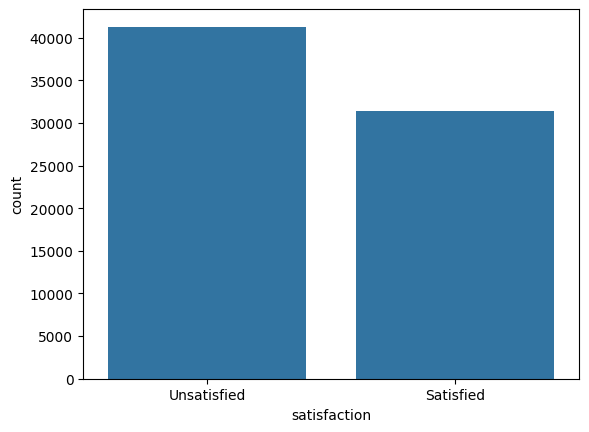

In [98]:
sns.countplot(data=train_dataset['satisfaction'].apply(lambda label: 'Satisfied' if label == 'satisfied' else 'Unsatisfied').to_frame(), x='satisfaction')

### Train Dataset

First of all, we will split our variables according to its data type and representation for the problem (note that we are not considering the satisfaction column since it is our result and it will not be dealed as a categorical variable). After that we will start our pre processing state handling missing data.

Here we will use two different approaches:
  1. use the mean value of each range column to fill its zero values (because we are considering the range from 1 to 5)
  2. use the median of the values from the **Arrival Delay in Minutes** column to fill its missing values.

In [302]:
FREE_VARIABLES = ['Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Flight Distance', 'Age']
CATEGORICAL_VARIABLES = list(filter(lambda x: x != 'satisfaction', train_dataset.select_dtypes(include='object').columns.tolist()))
SCORE_VARIABLES = list(filter(lambda x: x not in FREE_VARIABLES, train_dataset.select_dtypes(include='int64').columns.tolist()))

In [303]:
adjust_type = lambda x: int(x)
train_dataset['Arrival Delay in Minutes'].fillna(train_dataset['Arrival Delay in Minutes'].mean(), inplace=True)
train_dataset['Arrival Delay in Minutes'] = train_dataset['Arrival Delay in Minutes'].apply(adjust_type)

for column in SCORE_VARIABLES:
    median_value = train_dataset[column][train_dataset[column] != 0].median()
    train_dataset[column] = train_dataset[column].replace(0, median_value)

Once the missing data was handled, we need to analyze the outliers values to start our normalization process. Lets see the distribution of the **Flight Distance** and **Age** variables. With a simple look at the graph we can notice that:
  1. on the **Flight Distance**, some outliers start to appear near 4000
  2. on the **Age** it seems that are no outliers, but we can stablish a limiar of 80 years old, since there is few instances of data greater than this value

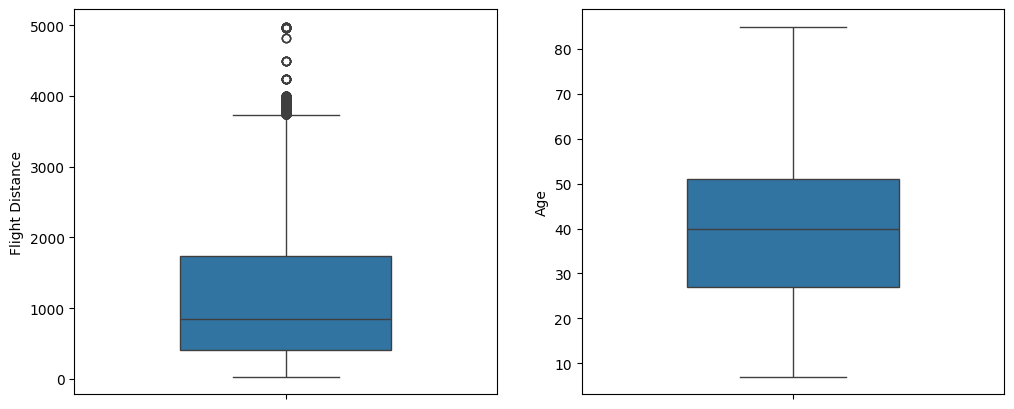

In [304]:
compare_boxplots(train_dataset, ['Flight Distance', 'Age'])

To handle outliers in the **Flight Distance** column we will use the **z-score** method, that takes in consideration the mean of the values and the standard deviation to cut out some edges based on a given threshold. To know more about the **z-score** method you can refer to [this link](https://www.linkedin.com/pulse/z-score-normalization-ml-concepts-com/).

After the application of the **z-score** method we observe that the number of samples in the resultant dataset is decreased, and looking to the updated boxplot we can see that **Flight Distance** column has no outliers.

In [305]:
processed_dataset = remove_outliers_z_score(train_dataset, ['Flight Distance'], 2)
processed_dataset = processed_dataset[processed_dataset['Age'] <= 80]
processed_dataset.shape, train_dataset.shape

((67982, 23), (72733, 23))

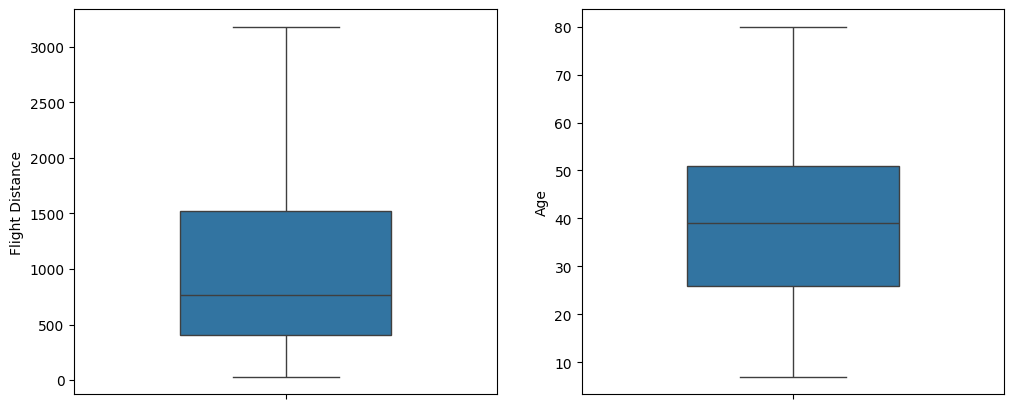

In [306]:
compare_boxplots(processed_dataset, ['Flight Distance', 'Age'])

When alanyzing the **Arrival Delay in Minutes** and **Departure Delay in Minutes** variables, we see how scattered these variables are, because there is no standard deviation neither median of values. We will need to go deeper to extract some knowledge about these variables.

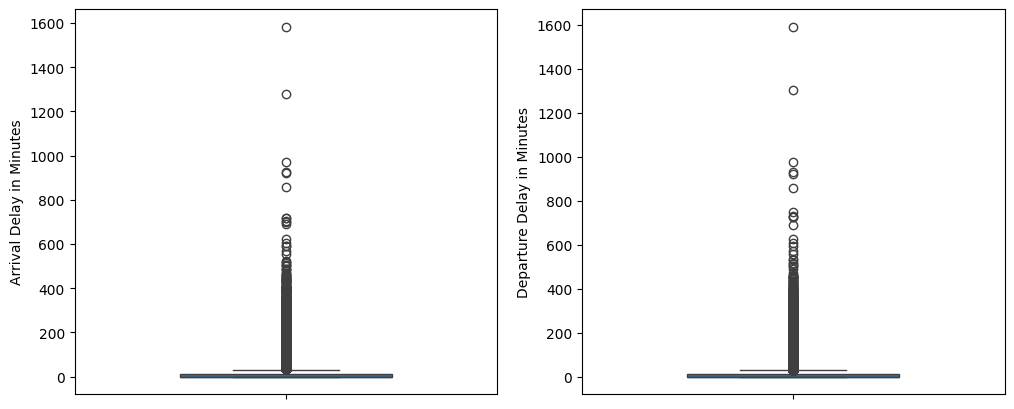

In [307]:
DELAY_VARIABLES = ['Arrival Delay in Minutes', 'Departure Delay in Minutes']
compare_boxplots(processed_dataset, DELAY_VARIABLES)

In [ ]:
# TODO - Relation with target variable

We will create ranges for all of our free variables, because once these variables are not controlled, it can lead to difficulties on the model trainning. By creating ranges for these variables we can group some instances, have insights, check relations and characteristics about these groups (also the problem of the delay columns will be handled in a most controlled context).

In [308]:
%%capture
range_dataset = make_ranges(processed_dataset, FREE_VARIABLES)

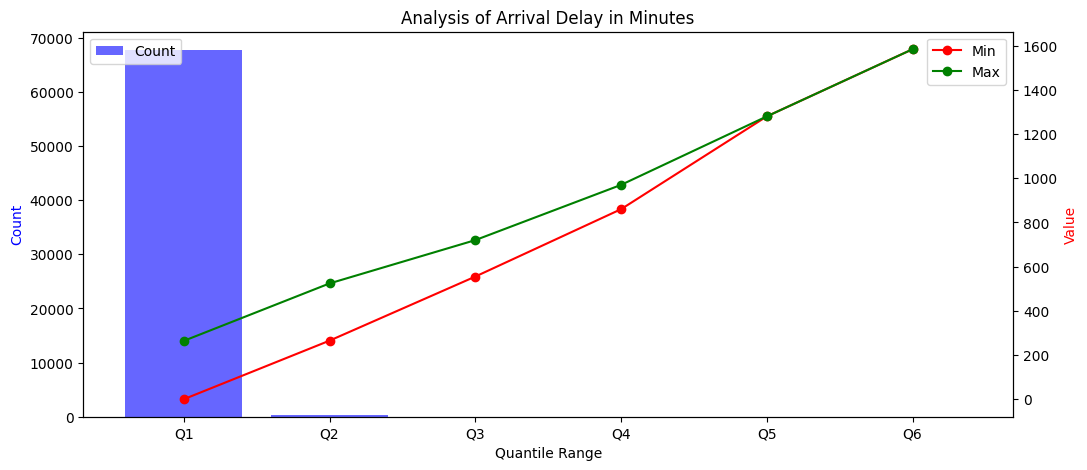

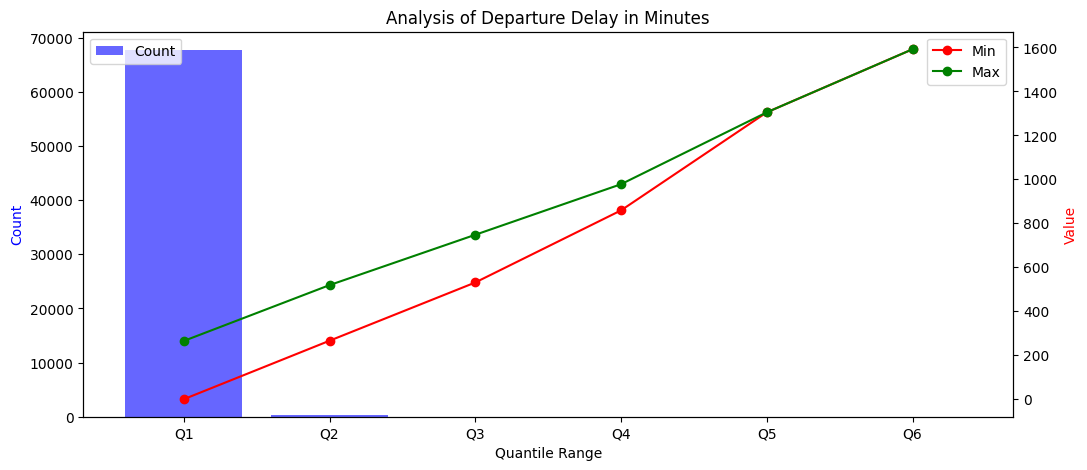

In [309]:
analysis = get_analysis(range_dataset, FREE_VARIABLES)

for column in DELAY_VARIABLES:
  plot_analysis(analysis, column)

How we can see in the graphs above, the most part of the delays consist in a intenal lower than **300 minutes**. If we search for a special case where the delay is zero, we will see that it consist in more than a half of our trainning data. WHAT TO DO ABOUT IT?

While we do not know, let's reduce our space by keeping only the data that represents the **Q1** values on the graph above


In [310]:
arrival_zeros = processed_dataset[processed_dataset['Arrival Delay in Minutes'] == 0.0]
departure_zeros = processed_dataset[processed_dataset['Departure Delay in Minutes'] == 0]
zeros = pd.concat([arrival_zeros, departure_zeros]).drop_duplicates()
zeros.shape[0], train_dataset.shape[0]

(45404, 72733)

In [311]:
%%capture
for column in DELAY_VARIABLES:
  processed_dataset = processed_dataset[processed_dataset[column] < 200]

range_dataset = make_ranges(processed_dataset, DELAY_VARIABLES)

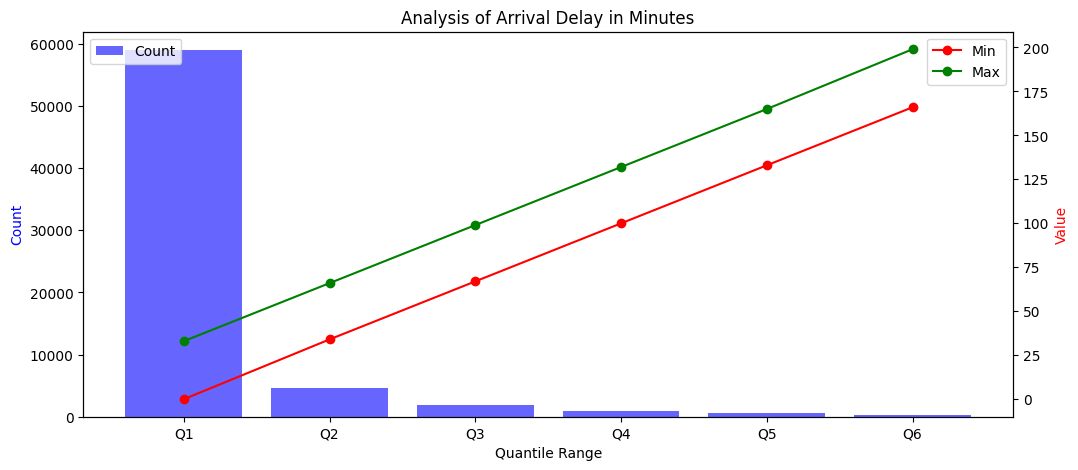

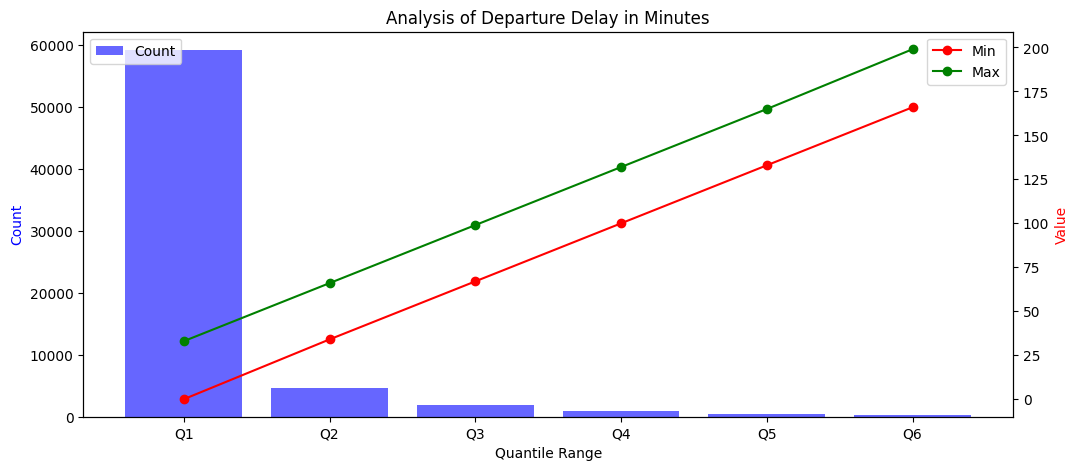

In [312]:
analysis = get_analysis(range_dataset, DELAY_VARIABLES)

for column in DELAY_VARIABLES:
  plot_analysis(analysis, column)

Let's create the ranges for our free variables so it can be considered in a most controlled context. below we can also see the distribution between the ranges and which interval was considered to make them.

After make the ranges, we will turn its data into integers, so we can have ordinal meaning in terms of distance, age and so on.

In [313]:
%%capture
range_dataset = make_ranges(processed_dataset, FREE_VARIABLES)

In [314]:
analysis = get_analysis(range_dataset, FREE_VARIABLES)
for key in list(analysis.keys()):
  print(f'{key} distribution: {analysis[key]}')

range_dataset = range_dataset.drop(columns=FREE_VARIABLES)

Arrival Delay in Minutes distribution: {'Q1': {'count': 59018, 'min': 0, 'max': 33}, 'Q2': {'count': 4645, 'min': 34, 'max': 66}, 'Q3': {'count': 1904, 'min': 67, 'max': 99}, 'Q4': {'count': 958, 'min': 100, 'max': 132}, 'Q5': {'count': 560, 'min': 133, 'max': 165}, 'Q6': {'count': 309, 'min': 166, 'max': 199}}
Departure Delay in Minutes distribution: {'Q1': {'count': 59116, 'min': 0, 'max': 33}, 'Q2': {'count': 4606, 'min': 34, 'max': 66}, 'Q3': {'count': 1912, 'min': 67, 'max': 99}, 'Q4': {'count': 942, 'min': 100, 'max': 132}, 'Q5': {'count': 518, 'min': 133, 'max': 165}, 'Q6': {'count': 300, 'min': 166, 'max': 199}}
Flight Distance distribution: {'Q1': {'count': 25111, 'min': 31, 'max': 556}, 'Q2': {'count': 18996, 'min': 557, 'max': 1081}, 'Q3': {'count': 8049, 'min': 1083, 'max': 1606}, 'Q4': {'count': 6165, 'min': 1607, 'max': 2131}, 'Q5': {'count': 5900, 'min': 2132, 'max': 2656}, 'Q6': {'count': 3173, 'min': 2657, 'max': 3182}}
Age distribution: {'Q1': {'count': 6649, 'min': 7

In [315]:
replacement = lambda x: int(x[1])
for column in range_dataset.columns:
  range_dataset[column] = range_dataset[column].apply(replacement)

In [316]:
for column in range_dataset.columns:
  processed_dataset.insert(1, column, range_dataset[column])

Now we will explore another step of the normalization process that will be the scale of the values. To this we will use the **min-max** scaler so we can have the free variables contained in a closed interval

In [317]:
scaler = MinMaxScaler()
processed_dataset[FREE_VARIABLES] = scaler.fit_transform(processed_dataset[FREE_VARIABLES])
processed_dataset = processed_dataset.drop(columns=FREE_VARIABLES)

Now we will encode our categorical variables to turn it in numerical data without meaning of order, quantity or so.

In [318]:
processed_dataset = pd.get_dummies(processed_dataset, columns=CATEGORICAL_VARIABLES)

Since the satisfaction column has an ordinal meaning, we will also transform it so the data can fit that meaning appropriately

In [319]:
replacement = lambda x: 2 if str(x).lower().strip() == 'satisfied' else 1
processed_dataset['satisfaction'] = processed_dataset['satisfaction'].apply(replacement)

Now, let's considere the processed_dataset our training dataset and to some instances or our data

In [320]:
train_dataset = adjust_column_names(processed_dataset)
train_dataset.head()

,Age,Flight Distance,Departure Delay,Arrival Delay,Inflight Wifi Service,Departure/Arrival Time Convenient,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,...,Satisfaction,Female,Male,Loyal Customer,Disloyal Customer,Business Travel,Personal Travel,Business Class,Eco Class,Eco Plus Class
0,1,1,1,1,3,4,3,1,5,3,...,1,False,True,True,False,False,True,False,False,True
1,2,1,1,1,3,2,3,3,1,3,...,1,False,True,False,True,True,False,True,False,False
2,2,3,1,1,2,2,2,2,5,5,...,2,True,False,True,False,True,False,True,False,False
3,2,2,1,1,2,5,5,5,2,2,...,1,True,False,True,False,True,False,True,False,False
4,5,1,1,1,3,3,3,3,4,5,...,2,False,True,True,False,True,False,True,False,False


### Validation and Test Datasets

First we will fill the missing values on the remaining datasets

In [ ]:
others_datasets = { 'validation': validation_dataset, 'test': test_dataset }

In [ ]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current['Arrival Delay in Minutes'].fillna(current['Arrival Delay in Minutes'].mean(), inplace=True)

  for column in SCORE_VARIABLES:
      median_value = current[column][current[column] != 0].median()
      current[column] = current[column].replace(0, median_value)

  others_datasets[key] = current

Applying on the new datasets the same **min-max** scaler value extracted from the training data preprocessing

In [ ]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current[FREE_VARIABLES] = scaler.transform(current[FREE_VARIABLES])
  others_datasets[key] = current

Now, for the free variables, we need to apply the same intervals of the trainning dataset

In [ ]:
# TODO

Adapting categorical variables with one-hot encoding method

In [ ]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current = pd.get_dummies(current, columns=CATEGORICAL_VARIABLES)
  others_datasets[key] = current

Let's replace the satisfaction column with integer values to give to the data a sequencial meaning

In [ ]:
replacement = lambda x: 2 if str(x).lower().strip() == 'satisfied' else 1
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current['satisfaction'] = current['satisfaction'].apply(replacement)
  others_datasets[key] = current

Finally let's apply the column names standard so the whole structure of the remaining datasets can follow the trainning dataset

In [ ]:
for key in list(others_datasets.keys()):
  others_datasets[key] = adjust_column_names(others_datasets[key].copy())